In [14]:
using PyPlot
using LinearAlgebra
using Statistics
using Random

Random.seed!(1234567);

# Effect of Hyperparameters on SGD

### Recall from last time: linear regression

Loss function is 
$$f_i(w) = \frac{1}{2} (w^T x_i - y_i)^2.$$
We'll sample a random dataset over $d$ dimensions in which
$$x_i \sim \mathcal{N}(0, I)$$
and for some constant unit vector $u$,
$$y_i = u^T x_i + \mathcal{N}(0,0.1^2).$$

In [2]:
struct LinRegDataset
    Xs :: Array{Array{Float64,1},1}
    Ys :: Array{Float64,1}
end

function generate_synthetic_dataset(d::Int64, n::Int64)
    Random.seed!(8675309);
    
    # generate random unit vector
    u = randn(d); u /= norm(u);
    
    Xs = [randn(d) for i = 1:n];
    Ys = [dot(u, Xs[i]) + 0.5 * randn() for i = 1:n];
    
    return LinRegDataset(Xs, Ys);
end

d = 100;
n = 5000;
    
TD = generate_synthetic_dataset(d, n);

In [3]:
function total_loss(TD :: LinRegDataset, w :: Array{Float64,1})
    return mean([(dot(w, TD.Xs[i]) - TD.Ys[i])^2 / 2 for i = 1:n]);
end

total_loss (generic function with 1 method)

In [4]:
function grad_fi(TD :: LinRegDataset, i::Int64, w :: Array{Float64,1})
    return TD.Xs[i] * (dot(w, TD.Xs[i]) - TD.Ys[i]);
end

function total_grad(TD :: LinRegDataset, w :: Array{Float64,1})
    n = length(TD.Xs);
    return mean([grad_fi(TD, i, w) for i = 1:n]);
end

total_grad (generic function with 1 method)

In [5]:
function stochastic_gradient_descent(TD :: LinRegDataset, alpha :: Float64, num_iters :: Int64, loss_interval :: Int64)
    n = length(TD.Xs);
    d = length(TD.Xs[1]);
    # initialize the parameters to zero
    w = zeros(d);
    # vector to store loss after t iterations
    measurement_times = Float64[0];
    loss_at_t = Float64[total_loss(TD, w)];
    # run iteratively
    for t = 1:num_iters
        i = rand(1:n);
        w = w - alpha * grad_fi(TD, i, w);
        if t % loss_interval == 0
            push!(measurement_times, t);
            push!(loss_at_t, total_loss(TD, w));
        end
    end
    return (measurement_times, loss_at_t)
end

function stochastic_gradient_descent_until(TD :: LinRegDataset, alpha :: Float64, num_iters :: Int64, loss_interval :: Int64, loss_threshold :: Float64)
    n = length(TD.Xs);
    d = length(TD.Xs[1]);
    # initialize the parameters to zero
    w = zeros(d);
    # run iteratively
    for t = 1:num_iters
        i = rand(1:n);
        w = w - alpha * grad_fi(TD, i, w);
        if t % loss_interval == 0
            if (total_loss(TD, w) <= loss_threshold)
                return t;
            end
        end
    end
    return num_iters;
end



stochastic_gradient_descent_until (generic function with 1 method)

In [6]:
# function to estimate the size of a noise ball
function estimate_noise_ball_size(losses :: Array{Float64,1})
    return mean(losses[ceil(length(losses/2)):end]);
end

estimate_noise_ball_size (generic function with 1 method)

In [7]:
alphas = [0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005];
num_iters = 100000;
loss_interval = 10;
ball_sizes = [estimate_noise_ball_size(stochastic_gradient_descent(TD, alpha, num_iters, loss_interval)[2]) for alpha in alphas];

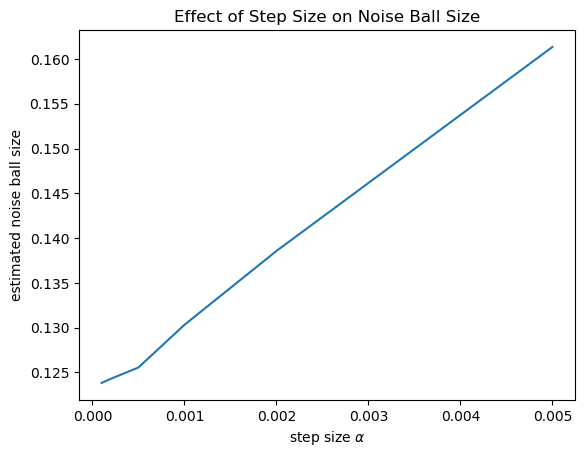

In [8]:
plot(alphas, ball_sizes);
xlabel("step size \$\\alpha\$");
ylabel("estimated noise ball size");
title("Effect of Step Size on Noise Ball Size");

In [9]:
loss_threshold = 0.18;
convergence_times = [mean([stochastic_gradient_descent_until(TD, alpha, num_iters, loss_interval, loss_threshold) for k=1:5]) for alpha in alphas];

loss_threshold2 = 0.25;
convergence_times2 = [mean([stochastic_gradient_descent_until(TD, alpha, num_iters, loss_interval, loss_threshold2) for k=1:5]) for alpha in alphas];

loss_threshold3 = 0.35;
convergence_times3 = [mean([stochastic_gradient_descent_until(TD, alpha, num_iters, loss_interval, loss_threshold3) for k=1:5]) for alpha in alphas];


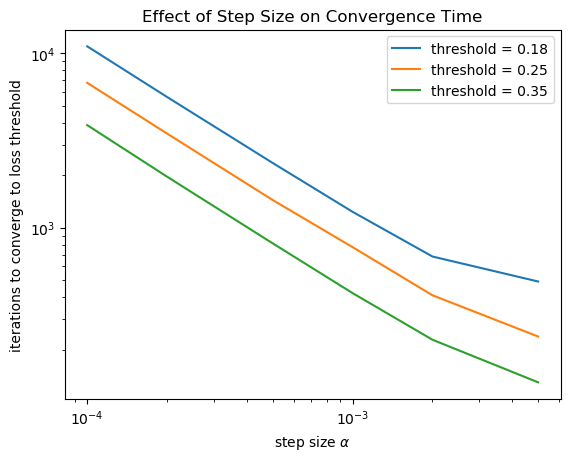

In [10]:
loglog(alphas, convergence_times; label="threshold = $(loss_threshold)");
loglog(alphas, convergence_times2; label="threshold = $(loss_threshold2)");
loglog(alphas, convergence_times3; label="threshold = $(loss_threshold3)");
xlabel("step size \$\\alpha\$");
ylabel("iterations to converge to loss threshold");
legend();
title("Effect of Step Size on Convergence Time");

### Evaluating minibatching

In [11]:
function minibatch_sgd(TD :: LinRegDataset, alpha :: Float64, batch_size :: Int64, num_iters :: Int64, loss_interval :: Int64)
    n = length(TD.Xs);
    d = length(TD.Xs[1]);
    # initialize the parameters to zero
    w = zeros(d);
    # vector to store loss after t iterations
    measurement_times = Float64[0];
    loss_at_t = Float64[total_loss(TD, w)];
    # run iteratively
    for t = 1:num_iters
        w = w - alpha * mean([grad_fi(TD, rand(1:n), w) for b = 1:batch_size]);
        if t % loss_interval == 0
            push!(measurement_times, t);
            push!(loss_at_t, total_loss(TD, w));
        end
    end
    return (measurement_times, loss_at_t)
end

minibatch_sgd (generic function with 1 method)

In [12]:
alpha = 0.002;
loss_interval = 10;
batch_sizes = [1, 2, 4, 8, 16, 32, 64, 128, 256];
ball_sizes_mb = [estimate_noise_ball_size(minibatch_sgd(TD, alpha, b, num_iters, loss_interval)[2]) for b in batch_sizes];


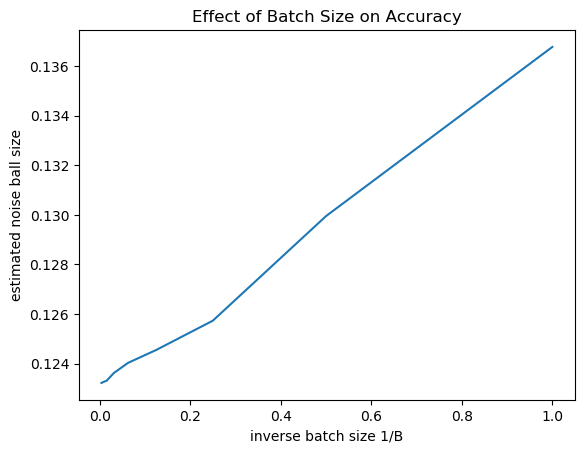

In [13]:
plot(1 ./ batch_sizes, ball_sizes_mb);
xlabel("inverse batch size 1/B");
ylabel("estimated noise ball size");
title("Effect of Batch Size on Accuracy");